Goal : Long term meomory with SqLite

Step 1: importing required packages

In [ ]:
! pip install  langgraph
! pip install langchain 
! pip install langchain_core_google_genai 
! pip install typing_extensions 
! pip install langchain_core


In [ ]:
from langgraph.graph import START, END, StateGraph, add_messages , MessagesState
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal, Annotated
from typing_extensions import TypedDict 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage ,RemoveMessage,SystemMessage
from _collections_abc import Sequence
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

c:\Users\star\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 2: Define State

In [ ]:
class State(MessagesState):
    summary:str

Step 3: Define node

In [ ]:
chat = ChatGoogleGenerativeAI(model="gemini-flash-latest", temperature=0, seed  =365)


In [ ]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    system_message=f"here's quick summary of what's been disscuss so far: {state.get('summary', '')} . keep this in mind as you answer the next question."
    response = chat.invoke([SystemMessage(content=system_message)] + state["messages"])
    response.pretty_print()
    
    return {"messages":[response]}

In [ ]:
def summarize_messages(state: State) -> State:
    print(f"\n-------> ENTERING trim_messages:")
    
    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}: {i.content}\n\n"
        
    summary_instructions = f'''
Update the ongoing summary by incorporating the new lines of conversation below.  
Build upon the previous summary rather than repeating it so that the result  
reflects the most recent context and developments.
Previous Summary:
{state.get("summary", "")}

New Conversation:
{new_conversation}
'''
    
    print(summary_instructions)
    
    summary = chat.invoke([HumanMessage(summary_instructions)])
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:]]
    
    return {"messages":remove_messages, "summary":summary.content}

Step 4: define graph

In [ ]:

graph = StateGraph(State)

In [ ]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("summarize_messages", summarize_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "summarize_messages")

In [ ]:
db_path="C:\Users\star\langgraph module\langgraph.db"
cone=sqlite3.connect(database=db_path,check_same_thread=False)

In [ ]:
checkerpoint= SqliteSaver(cone)
graph_compiled = graph.compile(checkerpoint)

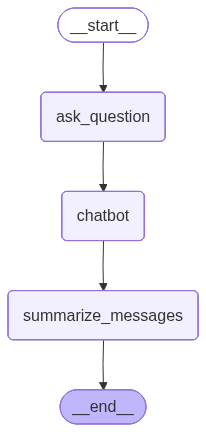

In [ ]:
graph_compiled

In [ ]:
config1 = {"configurable": {"thread_id": "1"}}

Step 5: Test the graph

In [ ]:
graph_compiled.invoke({"messages": []},config1)